In [ ]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\wine.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
x = df.drop(columns=['Customer_Segment'])
y = df['Customer_Segment']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=42)

y_train = y_train - 1
y_test = y_test - 1

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgbc',XGBClassifier(random_state=42, enable_categorical=True))
])

In [ ]:
param_dist = {
    'xgbc__n_estimators': [50, 100, 300],
    'xgbc__learning_rate': [0.01, 0.1, 1, 10],
    'xgbc__max_depth' : [5, 12, 20],
    'xgbc__subsample' : [0.3, 0.7, 1.0],
    'xgbc__reg_alpha' : [0.01, 0.1, 1],
    'xgbc__reg_lambda' : [1,5,10],
    'xgbc__gamma' : [0,1,5],
    'xgbc__colsample_bytree': [0.5, 0.7, 1.0],
    'xgbc__min_child_weight':[1,3,5]
}

random_search = HalvingRandomSearchCV(pipeline,
param_distributions=param_dist,
scoring='accuracy',
cv=5,
n_jobs=-1
)

random_search.fit(x_train, y_train)
print(random_search.best_params_)

{'subsample': 0.3, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(x_test)
print(y_pred)

In [ ]:
proba = best_model.predict_proba(x_test)
print(proba)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\winepredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = best_model.predict_proba(prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

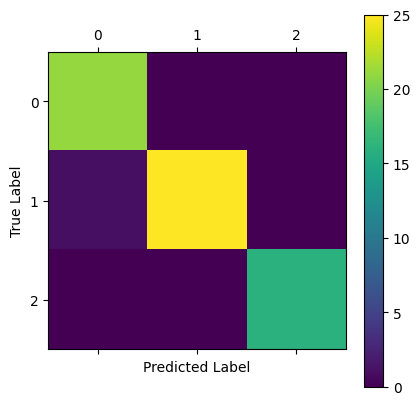

In [13]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Text(113.9222222222222, 0.5, 'true value')

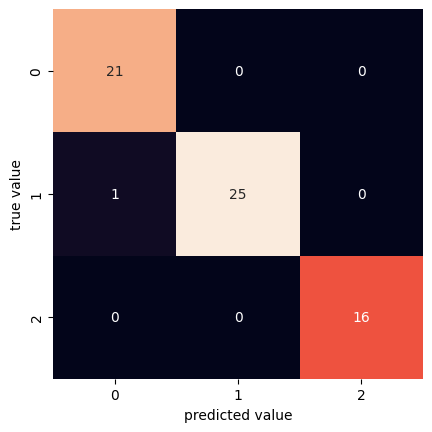

In [14]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9841269841269841

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.96      0.98        26
           2       1.00      1.00      1.00        16

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.99        63
weighted avg       0.98      0.98      0.98        63



In [16]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [1.         0.91304348 1.         0.95652174 1.        ]
Mean CV Accuracy: 0.9739130434782609


1.0


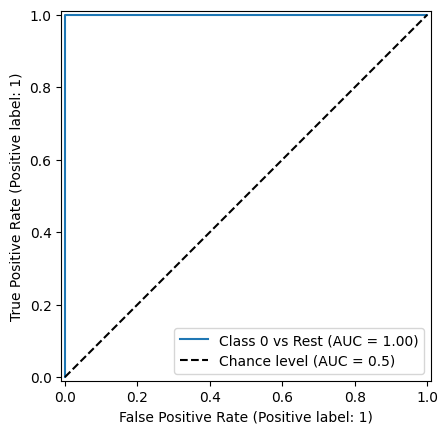

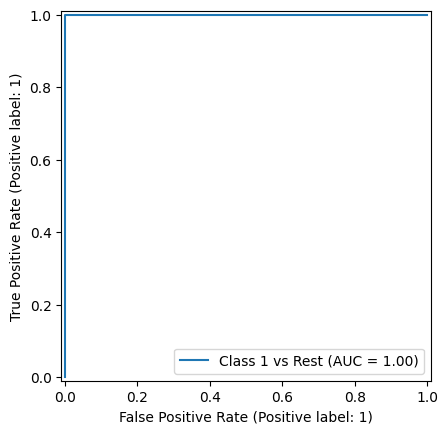

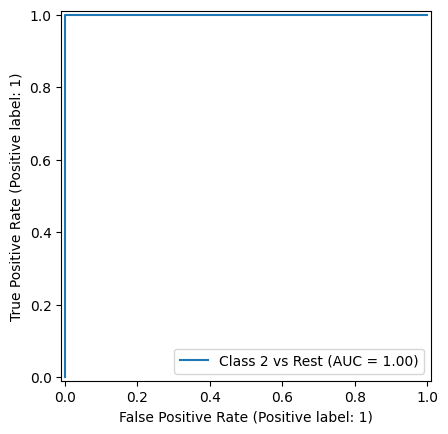

In [17]:
y_prob = best_model.predict_proba(x_test)

roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(roc_auc_ovr)

y_test_bin = label_binarize(y_test, classes = best_model.classes_)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

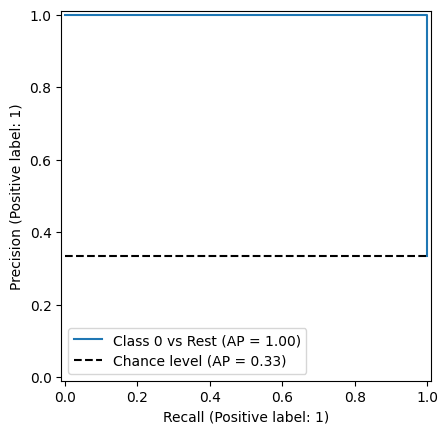

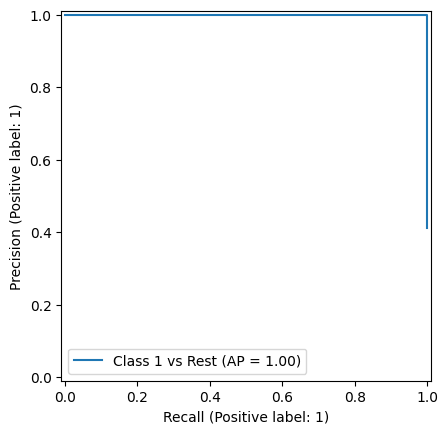

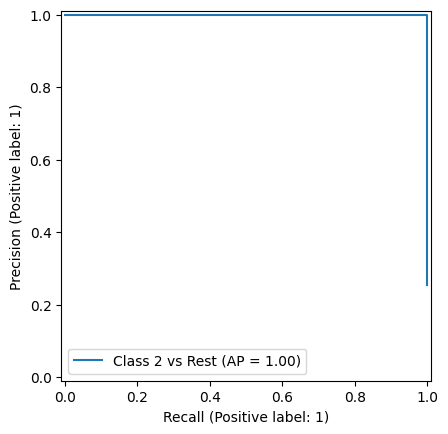

In [18]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

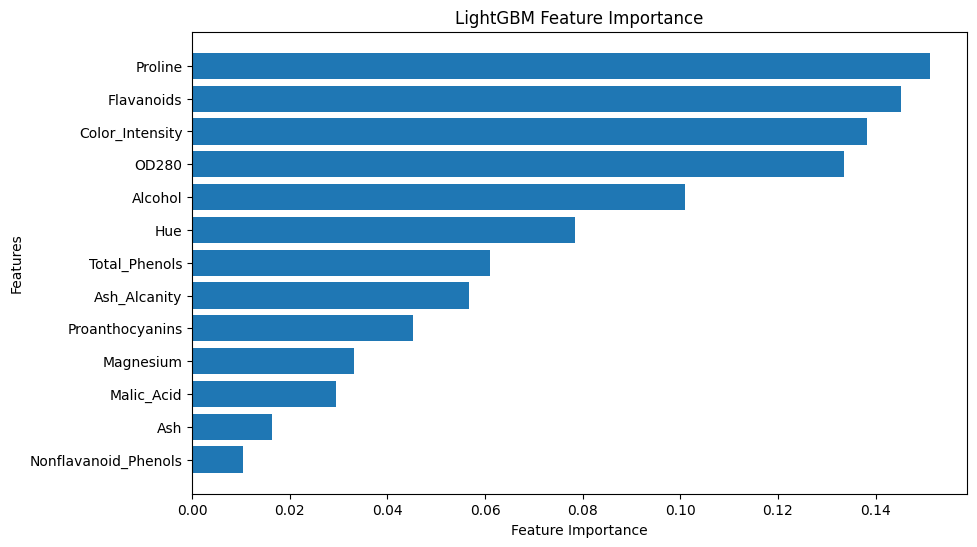

In [19]:
feature_importance = pd.DataFrame({'Feature': x_train.columns, 
                                   'Importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)